In [17]:
import pandas as pd
df = pd.read_csv('/Users/d062864/Documents/01_code/pythonStarter/data/books.csv')
df['title'] = 'default value'
df['authors'] = 'default value'
df['isbn'] = 'default value'
df['ddc'] = 'default value'



In [19]:
import requests
import json

baseUrlGoogle = 'https://www.googleapis.com/books/v1/volumes?q='


for index, row in df.iterrows():
    #get title, author, isbn from google
    searchUrl = baseUrlGoogle + row['query'] + '&maxResults=1&orderBy=relevance'
    searchRes = requests.get(searchUrl)
    searchJSON = json.loads(json.dumps(searchRes.json()))
    row['title']=searchJSON['items'][0]['volumeInfo']['title']
    row['authors']=searchJSON['items'][0]['volumeInfo']['authors']
    row['isbn']=searchJSON['items'][0]['volumeInfo']['industryIdentifiers'][0]['identifier']

In [27]:
import xmltodict

baseUrlOCLC = 'http://classify.oclc.org/classify2/Classify?isbn='

for index, row in df.iterrows():
    #get ddc from oclc
    searchUrl = baseUrlOCLC + row['isbn'] + '&summary=true'
    searchRes = requests.get(searchUrl)
    searchJSON = json.loads(json.dumps(xmltodict.parse(searchRes.content)))
    try:
        row['ddc'] = searchJSON['classify']['recommendations']['ddc']['mostPopular']['@nsfa']
    except Exception as e:
        row['ddc'] = 0

9781501144318
'recommendations'
9781864712124
'recommendations'
9780671023379
'recommendations'
OCLC:319886358
'recommendations'
0691136408
'recommendations'
9781595620019
'recommendations'
9783746727288
'recommendations'
9781408807323
'recommendations'
9780712676090
'recommendations'
9781501135934
'recommendations'
9780753555620
'recommendations'


In [35]:
df.to_csv('/Users/d062864/Documents/01_code/pythonStarter/data/books_out.csv')

In [2]:
import pandas as pd
df = pd.read_csv('/Users/d062864/Documents/01_code/pythonStarter/data/books.csv')

In [68]:
df_map = df.drop('Unnamed: 0', axis=1)
df_map[['title','l1','l2']]

dfl1 = df_map[['l1']]
dfl2 = df_map[['l2']]

dfl1 = pd.DataFrame(pd.unique(dfl1.values.flatten()))
dfl2 = pd.DataFrame(pd.unique(dfl2.values.flatten()))

dfAllCats = dfl1.append(dfl2)
dfAllCats = dfAllCats.append({0:'All Books'},ignore_index=True)
dfAllNodes = dfAllCats.append(pd.DataFrame(df_map['title'].values.flatten()))

dfAllEdges = df_map[['l1','l2']]
dfAllEdges = dfAllEdges.drop_duplicates()
dfTitle=df_map[['title','l2']]
dfTitle=dfTitle.rename(columns={"title": "source"})
dfTitle=dfTitle.rename(columns={"l2": "target"})
dfAllEdges = dfAllEdges.rename(columns={"l2": "source"})
dfAllEdges = dfAllEdges.rename(columns={"l1": "target"})
dfAllEdges=dfAllEdges.append(dfTitle)

In [106]:
dfAllBooks=dfl1
dfAllBooks['target'] = 'All Books'
dfAllBooks=dfAllBooks.rename(columns={0:"source"})
dfAllEdges=dfAllEdges.append(dfAllBooks)
dfAllEdges=dfAllEdges[['target','source']]

In [107]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_nodes_from(dfAllNodes.values.flatten())
G.add_edges_from(dfAllEdges.values)

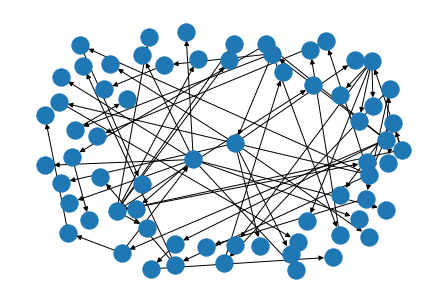

In [113]:
pos=nx.fruchterman_reingold_layout(G,k=0.6,iterations=10)
# pos=nx.kamada_kawai_layout(G,scale=0.9)
nx.draw(G,pos)
plt.show()

In [118]:
import plotly.graph_objects as go
labels=[k for k in pos.keys()]

Xn=[pos[k][0] for k in pos.keys()]
Yn=[pos[k][1] for k in pos.keys()]

node_trace = go.Scatter(
    x=Xn, y=Yn,
    mode='markers',
    hoverinfo='text',
    text=labels,
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

Xe=[]
Ye=[]
for e in G.edges():
    Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
    Ye.extend([pos[e[0]][1], pos[e[1]][1], None])

edge_trace = go.Scatter(
    x=Xe, y=Ye,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [119]:
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=dict(title= 'My Graph',  
            font= dict(family='Balto'),
            width=600,
            height=600,
            autosize=False,
            showlegend=False,
            xaxis=axis,
            yaxis=axis,
            margin=dict(
            l=40,
            r=40,
            b=85,
            t=100,
            pad=0,  
    ),
    hovermode='closest',
    plot_bgcolor='#efecea', #set background color            
    )

In [120]:
node_children = []
node_size = []

for node in G.nodes:
    node_children.append(len(nx.descendants(G,node)))
    node_size.append(len(nx.descendants(G,node))+20)

node_trace.marker.size = node_size
node_trace.marker.color = node_children

In [83]:
def make_annotations(pos, anno_text, font_size=14, font_color='rgb(10,10,10)'):
    L=len(pos)
    if len(anno_text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = []
    for k in range(L):
        annotations.append(dict(text=anno_text[k], 
                                x=Xn[k], 
                                y=Yn[k]+0.075,#this additional value is chosen by trial and error
                                xref='x1', yref='y1',
                                font=dict(color= font_color, size=font_size),
                                showarrow=False)
                          )
    return annotations  

In [121]:
import plotly.graph_objects as go
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Books i read',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                # annotations=make_annotations(pos, labels),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
plot(fig)

'temp-plot.html'

In [70]:
import plotly.graph_objects as go

In [55]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import networkx as nx
import plotly.graph_objs as go

import pandas as pd
from colour import Color
from datetime import datetime
from textwrap import dedent as d
import json

# import the css template, and pass the css template into dash
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.title = "Transaction Network"

YEAR=[2010, 2019]
ACCOUNT="A0001"

In [56]:
# styles: for right side hover/click component
styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}

In [62]:
app.layout = html.Div([
    #########################Title
    html.Div([html.H1("Transaction Network Graph")],
             className="row",
             style={'textAlign': "center"}),
    #############################################################################################define the row
    html.Div(
        className="row",
        children=[

            ############################################middle graph component
            html.Div(
                className="eight columns",
                children=[dcc.Graph(id="my-graph",
                                    figure=fig)],
            ),

            #########################################right side two output component
            # html.Div(
            #     className="two columns",
            #     children=[
            #         html.Div(
            #             className='twelve columns',
            #             children=[
            #                 dcc.Markdown(d("""
            #                 **Hover Data**

            #                 Mouse over values in the graph.
            #                 """)),
            #                 html.Pre(id='hover-data', style=styles['pre'])
            #             ],
            #             style={'height': '400px'}),

            #         html.Div(
            #             className='twelve columns',
            #             children=[
            #                 dcc.Markdown(d("""
            #                 **Click Data**

            #                 Click on points in the graph.
            #                 """)),
            #                 html.Pre(id='click-data', style=styles['pre'])
            #             ],
            #             style={'height': '400px'})
            #     ]
            # )
        ]
    )
])

In [63]:
app.run_server(debug=False)

* Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [02/Mar/2020 15:44:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2020 15:44:42] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2020 15:44:42] "GET /_dash-dependencies HTTP/1.1" 200 -
